### Imports

In [0]:
import keras # Importing Keras
from keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from keras.datasets import fashion_mnist # Import the fashion-mnist dataset
from keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from keras.models import Model # The class used to create a model
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils # Utilities to manipulate numpy arrays
from tensorflow import set_random_seed # Used for reproducible experiments
from keras.preprocessing.image import ImageDataGenerator # Used for image dataset handling

import gc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Data manipulation

**Task**: Given an image decide if contains a car or a dog

**[Data](https://drive.google.com/file/d/1Kjrrga40HkSAun63Gk9t7UClLJ0frqzE/view?usp=sharing)**:
- The data are RGB images of arbitrary size that are resized to 64*64
- We will use a CNN to classify them (no need to flatten as when using an MLP)
- The values of the inputs are in [0, 255] so we normalize them to [0, 1]

In [14]:
batch_size = 128
classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print(input_shape)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, classes)
y_test = keras.utils.to_categorical(y_test, classes)


(28, 28, 1)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Plotting results

In [0]:
def plot_history(hs, epochs, metric):
    plt.clf()
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 16
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric))
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric))
    x_ticks = np.arange(0, epochs + 1)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


### Cleaning up

In [0]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()


### Model creation

- We will use a Functional Model.
    - It is more flexible than the `Sequential` model but ...
    - We need to be careful with the sizes of the layers.
- The first layer should always be an `Input` layer where we specify the input of the model, e.g., the training data
- The other layers can be whatever we want and for each layer we must:
    - Define the input to the layer, i.e., another layer.
    - Define the number of units which also defines the output size.
        - The output size must be always equal to the number of units of the next layer.


In [0]:
def train_model(
        optimizer,
        epochs=100,
        conv_layers=2,
        conv_activation='relu',
        conv_dropout=False,
        output_activation='softmax'):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_random_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=8*(2**i),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=0.2,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
        elif conv_dropout==0.5:
            x = Dropout(
                rate=0.5,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    output = Dense(
        units=classes,
        activation=output_activation,
        name='Output'
    )(x)

     # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    hs = model.fit(x_train, y_train,
          #validation_split=0.2,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs


### Without dropout

In [35]:
# Using Adam
optimizer = Adam(lr=0.001)

# 3 Convolutional Layers and Logistic Regression
conv_no_drop_model_adam, conv_no_drop_hs_adam = train_model(
    optimizer=optimizer,
    epochs=epochs,
    conv_layers=3,
    conv_activation='relu',
    conv_dropout=False,
    #output_activation='sigmoid'
)

# Evaluate on test data and show all the results.
conv_no_drop_eval_adam = conv_no_drop_model_adam.evaluate(
    x_test,
    y_test,
    verbose=1
)

clean_up(model=conv_no_drop_model_adam)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 5s 88us/step - loss: 0.1186 - acc: 0.9529 - val_loss: 0.0863 - val_acc: 0.9655
Epoch 2/12
60000/60000 [==============================] - 5s 84us/step - loss: 0.0768 - acc: 0.9693 - val_loss: 0.0729 - val_acc: 0.9709
Epoch 3/12
60000/60000 [==============================] - 5s 85us/step - loss: 0.0673 - acc: 0.9734 - val_loss: 0.0681 - val_acc: 0.9729
Epoch 4/12
60000/60000 [==============================] - 5s 84us/step - loss: 0.0628 - acc: 0.9753 - val_loss: 0.0638 - val_acc: 0.9752
Epoch 5/12
60000/60000 [==============================] - 5s 84us/step - loss: 0.0593 - acc: 0.9769 - val_loss: 0.0618 - val_acc: 0.9758
Epoch 6/12
60000/60000 [==============================] - 5s 84us/step - loss: 0.0561 - acc: 0.9780 - val_loss: 0.0595 - val_acc: 0.9769
Epoch 7/12
60000/60000 [==============================] - 5s 84us/step - loss: 0.0541 - acc: 0.9788 - val_loss: 0.0594 - val_acc

### Results without dropout

Train Loss     : 0.04657
Validation Loss: 0.05146
Test Loss      : 0.05146
---
Train Accuracy     : 0.98195
Validation Accuracy: 0.98013
Test Accuracy      : 0.98013


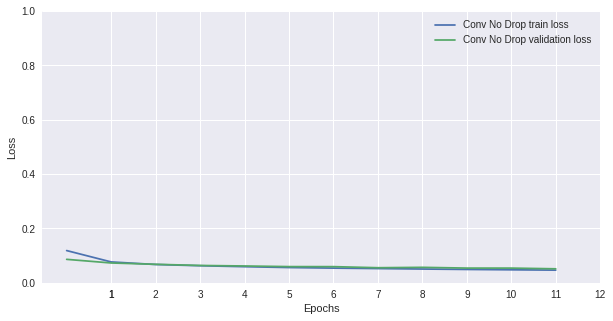

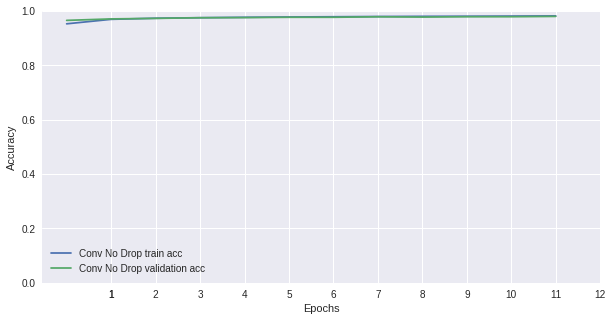

In [36]:
print("Train Loss     : {0:.5f}".format(conv_no_drop_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(conv_no_drop_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(conv_no_drop_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(conv_no_drop_hs_adam.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(conv_no_drop_hs_adam.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(conv_no_drop_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(hs={'Conv No Drop': conv_no_drop_hs_adam}, epochs=epochs, metric='loss')
plot_history(hs={'Conv No Drop': conv_no_drop_hs_adam}, epochs=epochs, metric='acc')

### With dropout 0.2

In [21]:
# Using Adam
optimizer = Adam()

# 3 Convolutional Layers and Logistic Regression
conv_drop_model_adam, conv_drop_hs_adam = train_model(
    optimizer=optimizer,
    epochs=epochs,
    conv_layers=3,
    conv_activation='relu',
    conv_dropout=True,
    output_activation='sigmoid'
)

# Evaluate on test data and show all the results.
conv_drop_eval_adam = conv_drop_model_adam.evaluate(
    x_test,
    y_test,
    verbose=1
)

clean_up(model=conv_drop_model_adam)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 11s 186us/step - loss: 0.1868 - acc: 0.9294 - val_loss: 0.1055 - val_acc: 0.9577
Epoch 2/12
60000/60000 [==============================] - 10s 170us/step - loss: 0.1049 - acc: 0.9576 - val_loss: 0.0889 - val_acc: 0.9654
Epoch 3/12
60000/60000 [==============================] - 10s 166us/step - loss: 0.0926 - acc: 0.9629 - val_loss: 0.0810 - val_acc: 0.9687
Epoch 4/12
60000/60000 [==============================] - 10s 169us/step - loss: 0.0858 - acc: 0.9657 - val_loss: 0.0755 - val_acc: 0.9712
Epoch 5/12
60000/60000 [==============================] - 10s 169us/step - loss: 0.0811 - acc: 0.9680 - val_loss: 0.0729 - val_acc: 0.9717
Epoch 6/12
60000/60000 [==============================] - 6s 94us/step - loss: 0.0779 - acc: 0.9690 - val_loss: 0.0697 - val_acc: 0.9735
Epoch 7/12
60000/60000 [==============================] - 5s 87us/step - loss: 0.0754 - acc: 0.9701 - val_loss: 0.0674

### No dropout vs. dropout = 0.2

Train Loss     : 0.06755
Validation Loss: 0.06195
Test Loss      : 0.06195
---
Train Accuracy     : 0.97343
Validation Accuracy: 0.97595
Test Accuracy      : 0.97595


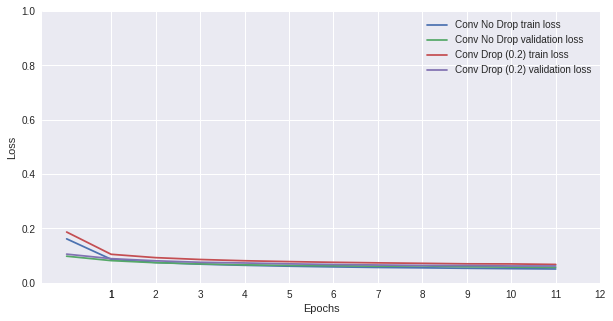

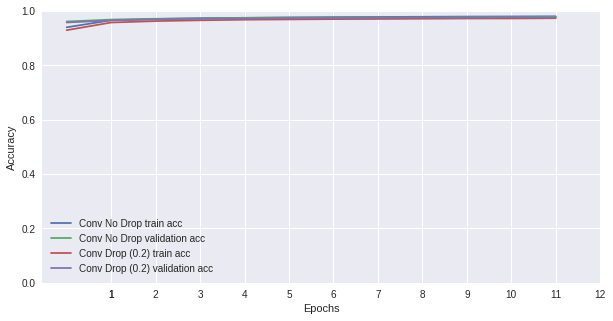

In [22]:
print("Train Loss     : {0:.5f}".format(conv_drop_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(conv_drop_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(conv_drop_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(conv_drop_hs_adam.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(conv_drop_hs_adam.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(conv_drop_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(
    hs={
        'Conv No Drop': conv_no_drop_hs_adam,
        'Conv Drop (0.2)': conv_drop_hs_adam
    },
    epochs=epochs,
    metric='loss'
)
plot_history(
    hs={
        'Conv No Drop': conv_no_drop_hs_adam,
        'Conv Drop (0.2)': conv_drop_hs_adam
    },
    epochs=epochs,
    metric='acc'
)

**With dropout 0.5**

In [23]:
# Using Adam
optimizer = Adam()

# 3 Convolutional Layers and Logistic Regression
conv_drop05_model_adam, conv_drop05_hs_adam = train_model(
    optimizer=optimizer,
    epochs=epochs,
    conv_layers=3,
    conv_activation='relu',
    conv_dropout=0.5,
    output_activation='sigmoid'
)

# Evaluate on test data and show all the results.
conv_drop05_eval_adam = conv_drop05_model_adam.evaluate(
    x_test,
    y_test,
    verbose=1
)

clean_up(model=conv_drop_model_adam)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 6s 96us/step - loss: 0.1868 - acc: 0.9294 - val_loss: 0.1055 - val_acc: 0.9577
Epoch 2/12
60000/60000 [==============================] - 5s 91us/step - loss: 0.1049 - acc: 0.9576 - val_loss: 0.0888 - val_acc: 0.9654
Epoch 3/12
60000/60000 [==============================] - 6s 92us/step - loss: 0.0925 - acc: 0.9629 - val_loss: 0.0810 - val_acc: 0.9687
Epoch 4/12
60000/60000 [==============================] - 6s 92us/step - loss: 0.0857 - acc: 0.9657 - val_loss: 0.0754 - val_acc: 0.9712
Epoch 5/12
60000/60000 [==============================] - 5s 92us/step - loss: 0.0811 - acc: 0.9680 - val_loss: 0.0729 - val_acc: 0.9719
Epoch 6/12
60000/60000 [==============================] - 5s 91us/step - loss: 0.0779 - acc: 0.9691 - val_loss: 0.0697 - val_acc: 0.9736
Epoch 7/12
60000/60000 [==============================] - 6s 92us/step - loss: 0.0754 - acc: 0.9702 - val_loss: 0.0674 - val_acc

**No dropout vs. dropout = 0.5**

Train Loss     : 0.06754
Validation Loss: 0.06140
Test Loss      : 0.06140
---
Train Accuracy     : 0.97347
Validation Accuracy: 0.97631
Test Accuracy      : 0.97631


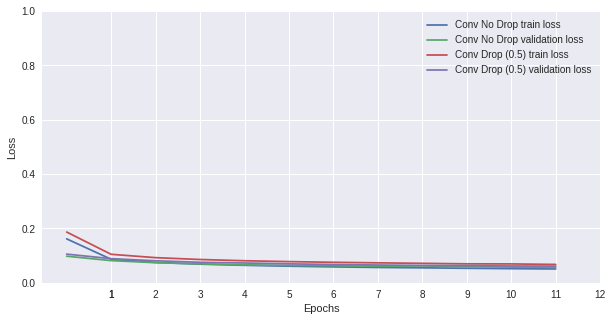

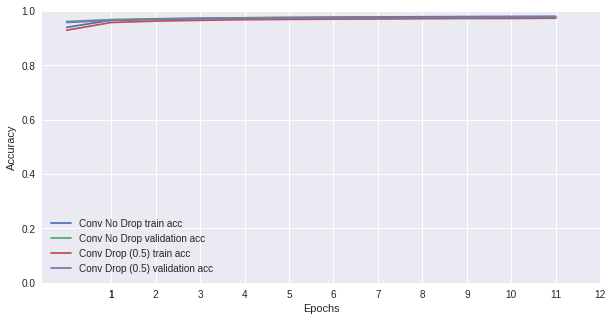

In [24]:
print("Train Loss     : {0:.5f}".format(conv_drop05_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(conv_drop05_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(conv_drop05_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(conv_drop05_hs_adam.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(conv_drop05_hs_adam.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(conv_drop05_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(
    hs={
        'Conv No Drop': conv_no_drop_hs_adam,
        'Conv Drop (0.5)': conv_drop05_hs_adam
    },
    epochs=epochs,
    metric='loss'
)
plot_history(
    hs={
        'Conv No Drop': conv_no_drop_hs_adam,
        'Conv Drop (0.5)': conv_drop05_hs_adam
    },
    epochs=epochs,
    metric='acc'
)

In [0]:
exit()